In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import root

# Pairwise maximum entropy: Dutch parliament as an Ising ferromagnet

## Importing and processing

Data van tweede kamer verkiezingen na 2008:

- 9 juni 2010
- 12 september 2012
- 15 maart 2017
- 17 maart 2021
- 22 november 2023

Zoek opdracht voor moties over een bepaalde periode:

In [2]:
# Periode kabinet Rutte II
search_query = "?$filter=Verwijderd eq false and Vergissing eq false and ((year(GewijzigdOp) eq 2012 and month(GewijzigdOp) ge 10) or (year(GewijzigdOp) ge 2013 and year(GewijzigdOp) le 2016) or (year(GewijzigdOp) eq 2017 and month(GewijzigdOp) le 2)) & orderby=GewijzigdOp"

In [3]:
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"
response = requests.get(url)
data = response.json()
data; 

Moties tijdens kabinet Rutte II:

In [4]:
# Define the initial URL
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"

# Initialize an empty list to store all the data points
all_data = []

# Loop to fetch all pages of data
while url:
    # Make an HTTP GET request to the current URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the JSON response to a Python dictionary
        data = response.json()
        
        # Extract the 'value' part of the JSON response and append it to the list
        all_data.extend(data['value'])
        
        # Check if there's a next page link
        if '@odata.nextLink' in data:
            # Update the URL to fetch the next page of data
            url = data['@odata.nextLink']
        else:
            # If there's no next page link, exit the loop
            url = None
    else:
        # If the request was not successful, print an error message and exit the loop
        print("Error:", response.status_code)
        url = None

# Convert the list of data points to a Pandas DataFrame
df = pd.DataFrame(all_data).sort_values(by='GewijzigdOp')

# Raw data array containing most motions during Rutte III. 
df


,Id,Besluit_Id,Soort,FractieGrootte,ActorNaam,ActorFractie,Vergissing,SidActorLid,SidActorFractie,Persoon_Id,Fractie_Id,GewijzigdOp,ApiGewijzigdOp,Verwijderd
0,76829575-3085-4c4f-b00e-2b4a256c7261,57e214d1-785a-4094-b9c9-348c6d587464,Voor,2,50PLUS,50PLUS,False,None,S-1-365867521-2120874753-800324394-1119149088-...,None,a34bf6c8-834e-4dba-b4d2-f2f1b3957bd2,2012-10-03T12:05:11.583+02:00,2019-07-26T11:41:08.4939605Z,False
1,cddf6f2f-1468-4497-9e1b-a3d2c11dacca,57e214d1-785a-4094-b9c9-348c6d587464,Voor,13,CDA,CDA,False,None,S-1-365867521-2120874753-3726368973-1295802169...,None,62c1a13c-85ff-40ed-90f7-a9546d61f869,2012-10-03T12:05:11.647+02:00,2019-07-26T12:58:51.0343326Z,False
2,feb332aa-aa11-4757-a50c-83edc9fc9c0c,57e214d1-785a-4094-b9c9-348c6d587464,Voor,5,ChristenUnie,ChristenUnie,False,None,S-1-365867521-2120874753-1996180723-1207380569...,None,d720f5af-0516-408a-b830-0b6ffb8a581c,2012-10-03T12:05:11.693+02:00,2019-07-26T13:03:34.3473918Z,False
3,006f83b4-640c-4989-975c-e2cef8d46214,57e214d1-785a-4094-b9c9-348c6d587464,Voor,12,D66,D66,False,None,S-1-365867521-2120874753-1399399692-1206643224...,None,4e9f6f5b-2544-4667-8134-6b85c4ebb4e0,2012-10-03T12:05:11.723+02:00,2019-07-26T13:03:11.0973372Z,False
4,00f20afa-94e2-49eb-bcf8-6b67cff1d6b9,57e214d1-785a-4094-b9c9-348c6d587464,Voor,4,GroenLinks,GroenLinks,False,None,S-1-365867521-2120874753-2386850707-1282307975...,None,8fd1a907-0355-4d27-8dc1-fd5a531b471e,2012-10-03T12:05:11.74+02:00,2019-07-26T13:04:08.4880753Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10181,cc485534-6391-40fd-9680-6659897cc302,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Voor,3,SGP,SGP,False,None,S-1-365867521-2120874753-1520352372-1191064225...,None,77f9b6f1-b1a9-4d1b-a05e-9936e79d8fa5,2017-02-24T12:18:15.947+01:00,2019-07-26T13:04:50.4256557Z,False
10180,79f0eefe-31d7-4f80-999e-1a159f9a71dd,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Voor,2,PvdD,PvdD,False,None,S-1-365867521-2120874753-3375217526-1184288014...,None,d3b4d880-ef37-4ce6-99ec-4940266ac466,2017-02-24T12:18:15.947+01:00,2019-07-26T12:59:20.331261Z,False
10182,442a8b4a-0ff7-4d2a-9747-934f1e3aa31f,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Tegen,12,PVV,PVV,False,None,S-1-365867521-2120874753-203711267-1259409971-...,None,65129918-f256-4975-9da4-488da34d6695,2017-02-24T12:18:15.947+01:00,2019-07-19T11:51:22.7312487Z,False
10183,ac2f2db1-e1d4-4d45-9e34-728aee3f6afb,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Voor,1,Van Vliet,Van Vliet,False,None,S-1-365867521-2120874753-2382917585-1146149961...,None,e2c3dd23-f247-430a-9c94-53f9f5c06c0b,2017-02-24T12:18:15.96+01:00,2019-07-26T12:55:59.4871186Z,False


Hoeveel moties waren er?

In [5]:
df['Besluit_Id'].nunique()

636

Partijen:

In [6]:
parties = df['ActorFractie'].unique()
parties

array(['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PvdD',
       'PvdA', 'PVV', 'SGP', 'SP', 'VVD', 'Bontes', 'Van Vliet',
       'Van Klaveren', 'GrBvK', '50PLUS/Baay-Timmerman', '50PLUS/Klein',
       'Klein', 'GrKÖ', 'Houwers', 'Monasch'], dtype=object)

We negeren de ondestaande afgesplinterde partijen (in haakjes hun originele partij):
- Bontes (PVV)
- Van Vliet (PVV) (sloot zich niet aan bij de tweede kamer fractie van de VVD in 2018)
- Klein (50Plus)
- Houwers (VVD)
- 50PLUS/Klein (50Plus)
- 50PLUS/Baay-Timmerman (50Plus)
- Van Klaveren (PVV)
- GrBvK (PVV)
- GrKÖ (PvdA)

Ik haal ook 50PLUS eruit want die partij viel uit elkaar.


In [7]:
filtered_parties = np.array(['PVV', 'PvdD', 'SP', 'GroenLinks', 'D66', 'ChristenUnie', 'SGP', 'CDA', 'PvdA','VVD'])
filtered_parties_short = np.array(['PVV','PvdD','SP', 'GL', 'D66', 'CU', 'SGP', 'CDA', 'PvdA','VVD'])

Process the dataframe:

In [8]:
# Remove ignored parties
processed_df = df[df['ActorFractie'].isin(filtered_parties)]

# Only keep cases where ActorNaam == ActorFractie, i.e. vote cast as a party
processed_df = processed_df[processed_df['ActorNaam'] == processed_df['ActorFractie']]

# Keep only relevant columns 
processed_df = processed_df[['Besluit_Id','Soort', 'ActorFractie']]

# Replace votes with numerical values
processed_df['Soort'] = processed_df['Soort'].map({'Voor': 1, 'Tegen': -1, 'Niet deelgenomen':0})
processed_df = processed_df.reset_index(drop=True)

processed_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1,CDA
1,57e214d1-785a-4094-b9c9-348c6d587464,1,ChristenUnie
2,57e214d1-785a-4094-b9c9-348c6d587464,1,D66
3,57e214d1-785a-4094-b9c9-348c6d587464,1,GroenLinks
4,57e214d1-785a-4094-b9c9-348c6d587464,1,PvdD
...,...,...,...
6255,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PvdA
6256,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,SGP
6257,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PvdD
6258,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PVV


In [9]:
fractiegroottes = df.groupby('ActorFractie')['FractieGrootte'].unique()
fractiegroottes = fractiegroottes.apply(lambda x: x[0])
fractiegroottes = fractiegroottes[fractiegroottes.index.isin(filtered_parties)]

fractiegroottes = fractiegroottes.loc[filtered_parties]
fractiegroottes

ActorFractie
PVV             15
PvdD             2
SP              15
GroenLinks       4
D66             12
ChristenUnie     5
SGP              3
CDA             13
PvdA            38
VVD             41
Name: FractieGrootte, dtype: int64

## Asymmetric dataset

In [10]:
pivot_df = processed_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
pivot_df = pivot_df[filtered_parties] # sorting columns
pivot_df

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
Besluit_Id,,,,,,,,,,
0001864e-d3c6-4624-a93f-a0f8dd4c04cc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
011086ac-713f-455c-bd37-22591ad5ceb4,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01eb5f6c-1a76-4c13-bdb1-c8d7eb9e6ca7,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02257872-4505-4fcc-b545-6ae5f15efefd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02435d6f-a53b-4791-91ce-3f1d098e7f1b,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
fec0ce7a-dfcd-43b0-a1b2-69d8ea1341b6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
fefa9414-00c9-4e33-bb3c-0baeafe18863,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ff078a51-edeb-4146-8580-a212222ed2f4,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


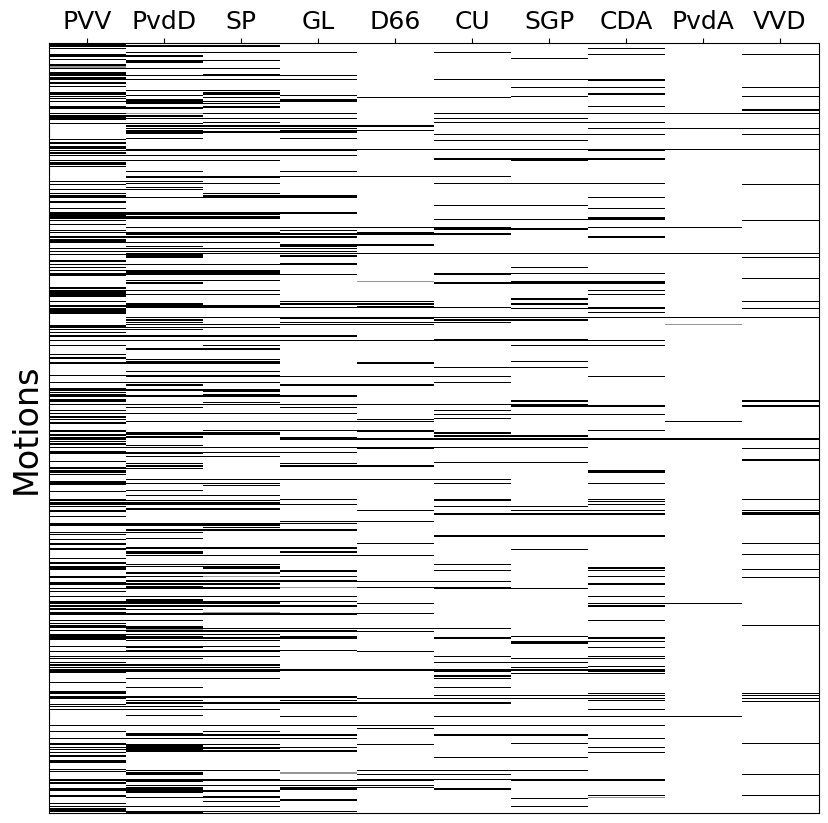

In [11]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(pivot_df, interpolation='none', cmap='Greys_r', extent=[0,10,0,10])
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=18); 
ax.set_yticks([]);
ax.set_ylabel('Motions', fontsize=24)
ax.xaxis.tick_top()


Gemiddelde stem per fractie: 

In [12]:
mean_votes = processed_df.groupby('ActorFractie')['Soort'].mean().reset_index()
mean_votes.columns = ['ActorFractie', 'Mean Vote']
mean_votes

,ActorFractie,Mean Vote
0,CDA,0.750799
1,ChristenUnie,0.770335
2,D66,0.824281
3,GroenLinks,0.680000
4,PVV,0.277955
5,PvdA,0.968051
6,PvdD,0.382400
7,SGP,0.789474
8,SP,0.513600
9,VVD,0.881978


In [13]:
correlation_matrix = pivot_df.corr()
correlation_matrix

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
ActorFractie,,,,,,,,,,
PVV,1.000000,0.226289,0.300301,0.113461,0.022881,-0.000100,0.066679,0.207652,-0.020791,0.079450
PvdD,0.226289,1.000000,0.690908,0.521069,0.290696,0.240943,0.079735,0.174870,0.129568,-0.072586
SP,0.300301,0.690908,1.000000,0.450338,0.294948,0.261819,0.095732,0.257350,0.174325,-0.063623
GroenLinks,0.113461,0.521069,0.450338,1.000000,0.438607,0.257984,0.090298,0.228607,0.268062,0.037668
D66,0.022881,0.290696,0.294948,0.438607,1.000000,0.328862,0.177140,0.162752,0.291779,0.160637
ChristenUnie,-0.000100,0.240943,0.261819,0.257984,0.328862,1.000000,0.544780,0.348081,0.228673,0.143321
SGP,0.066679,0.079735,0.095732,0.090298,0.177140,0.544780,1.000000,0.389159,0.200681,0.266969
CDA,0.207652,0.174870,0.257350,0.228607,0.162752,0.348081,0.389159,1.000000,0.292728,0.273882
PvdA,-0.020791,0.129568,0.174325,0.268062,0.291779,0.228673,0.200681,0.292728,1.000000,0.287287


Correlaties:

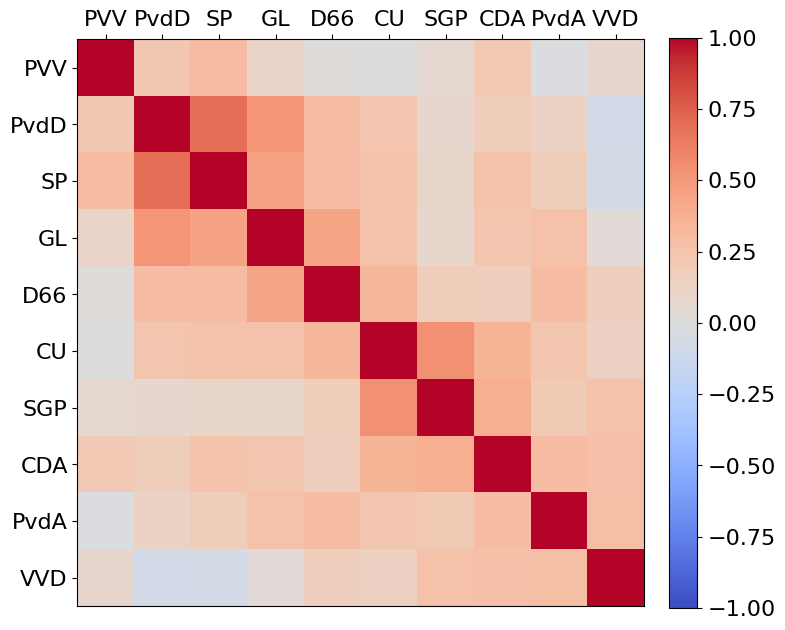

In [14]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.xaxis.tick_top()

## Symmetrised dataset

Maak de dataset symmetrisch. ("Voor" or "Tegen" heeft een arbitraire definitie.)

In [15]:
# Copy the DataFrame and flip the values in the 'Soort' column
sym_df = processed_df.copy()
sym_df['Soort'] = sym_df['Soort'].map({1: -1, -1: 1})

# Add a prefix to the 'Besluit_Id' column in the symmetrized DataFrame
sym_df['Besluit_Id'] = 'sym_' + sym_df['Besluit_Id'].astype(str)

# Concatenate the original DataFrame with the symmetrized one
sym_df = pd.concat([processed_df, sym_df], ignore_index=True)

sym_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1,CDA
1,57e214d1-785a-4094-b9c9-348c6d587464,1,ChristenUnie
2,57e214d1-785a-4094-b9c9-348c6d587464,1,D66
3,57e214d1-785a-4094-b9c9-348c6d587464,1,GroenLinks
4,57e214d1-785a-4094-b9c9-348c6d587464,1,PvdD
...,...,...,...
12515,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PvdA
12516,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,SGP
12517,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PvdD
12518,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PVV


In [16]:
sym_mean_votes = sym_df.groupby('ActorFractie')['Soort'].mean().reset_index()
sym_mean_votes.columns = ['ActorFractie', 'Mean Vote']
sym_mean_votes

,ActorFractie,Mean Vote
0,CDA,0.0
1,ChristenUnie,0.0
2,D66,0.0
3,GroenLinks,0.0
4,PVV,0.0
5,PvdA,0.0
6,PvdD,0.0
7,SGP,0.0
8,SP,0.0
9,VVD,0.0


In [17]:
sym_pivot_df = sym_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
sym_pivot_df = sym_pivot_df[filtered_parties] # sorting columns
sym_pivot_df; 

In [18]:
sym_correlation_matrix = sym_pivot_df.corr()
sym_correlation_matrix

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
ActorFractie,,,,,,,,,,
PVV,1.000000,0.306955,0.390088,0.268585,0.241214,0.213887,0.258579,0.340256,0.263578,0.280926
PvdD,0.306955,1.000000,0.744000,0.612800,0.466827,0.436103,0.346646,0.393285,0.399680,0.305112
SP,0.390088,0.744000,1.000000,0.632000,0.565947,0.538339,0.455272,0.530776,0.533973,0.426518
GroenLinks,0.268585,0.612800,0.632000,1.000000,0.741807,0.643771,0.576678,0.620304,0.706635,0.611822
D66,0.241214,0.466827,0.565947,0.741807,1.000000,0.753392,0.711892,0.678914,0.838658,0.769354
ChristenUnie,0.213887,0.436103,0.538339,0.643771,0.753392,1.000000,0.821372,0.724661,0.782123,0.722488
SGP,0.258579,0.346646,0.455272,0.576678,0.711892,0.821372,1.000000,0.750200,0.794893,0.773525
CDA,0.340256,0.393285,0.530776,0.620304,0.678914,0.724661,0.750200,1.000000,0.774760,0.747007
PvdA,0.263578,0.399680,0.533973,0.706635,0.838658,0.782123,0.794893,0.774760,1.000000,0.887470


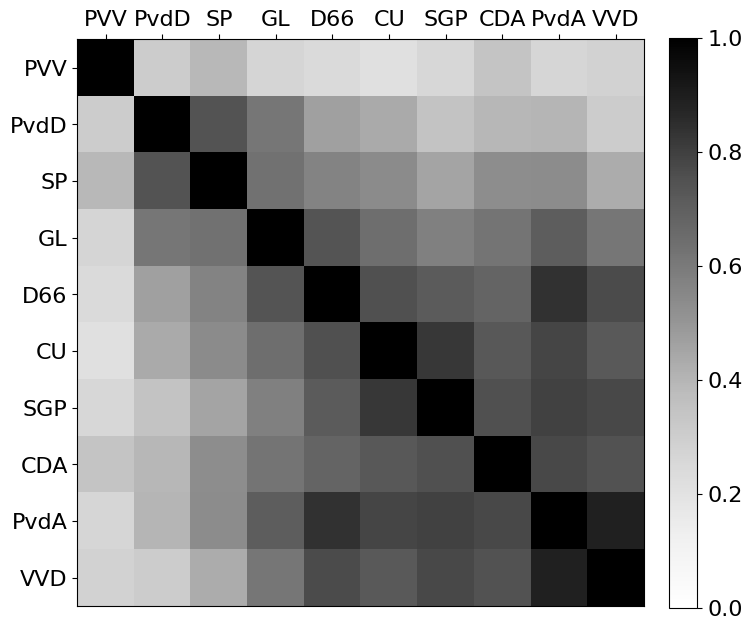

In [19]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(sym_correlation_matrix, cmap='Greys', vmin=0, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.xaxis.tick_top()

## Solving the inverse problem (symmetrised data)

$$ y = f'(x_0) (x - x_0) + f(x_0) $$

$$ x = x_0 - f(x_0) / f'(x_0)$$

$$
\begin{split}
p(\{\sigma_i\}) &= \frac{1}{Z(J)} \exp\bigg(-\frac{1}{2} E(\{\sigma_i\}, J)\bigg) \\
E(\{\sigma_i\}, J) &= - \sum_{ij} J_{ij} \sigma_i \sigma_j \\
Z(J) &= \sum_{\{\sigma_i\}} \exp\bigg(-\frac{1}{2} E(\{\sigma_i\}, J)\bigg) 
\end{split}
$$

We would like to solve the 45 simultaneous equations for the elements of $J$:

$$
f_{ab}(J) = \langle \sigma_a \sigma_b \rangle_{\mathrm{exp}} - \sum_{\{\sigma_i\}} \sigma_a \sigma_b \, p(\{\sigma_i\}) = 0
$$

To help us numerically, we will need the Jacobian:

$$
\begin{split}
2\frac{\partial f_{ab} (J) }{\partial J_{ij}} &= - 2\sum_{\{\sigma_i\}} \sigma_a \sigma_b \, \frac{\partial p(\{\sigma_i\})}{\partial J_{ij}} \\
&= - \sum_{\{\sigma_i\}} \sigma_a \sigma_b \, (\sigma_i \sigma_j - \langle \sigma_i \sigma_j \rangle ) \, p (\{ \sigma_i \}) \\
&= -\langle \sigma_a \sigma_b \sigma_i \sigma_j \rangle + \langle \sigma_a \sigma_b \rangle \langle \sigma_i \sigma_j \rangle
\end{split}
$$


Let's write matrix J as a vector to make notation easier.

$$
0 = f_i(\mathbf{v}_0) + \sum_{j} \frac{\partial f_i}{\partial v_j} (\mathbf{v} - \mathbf{v}_0)_j
$$

Let's call our Jacobian matrix $M_{ij} = \frac{\partial f_{i}}{\partial v_j}$. Then:

$$
\mathbf{v} = \mathbf{v}_0 - M^{-1} \mathbf{f}(\mathbf{v}_0)
$$

In [102]:
# function that takes a decimal number and returns a binary vector of given length
def decimal_to_binary_vector(decimal_number, vector_length):
    binary_string = bin(decimal_number)[2:]  # Convert decimal number to binary string
    binary_vector = [int(bit) for bit in binary_string]  # Convert binary string to binary vector
    
    # Add leading zeros to the binary vector
    while len(binary_vector) < vector_length:
        binary_vector.insert(0, 0)

    # Replace 0s with -1s in the binary vector
    binary_vector = [-1 if bit == 0 else bit for bit in binary_vector]

    return binary_vector

# all possible spin configurations
spins = np.array([decimal_to_binary_vector(i, 10) for i in range(2**10)])


In [103]:
# energy
def E(sigma, J): 
    energy = -(1/2)*np.dot(sigma, np.matmul(J, sigma))
    return energy

In [170]:
# probability distribution and partition function
def pspins(J):
    pspins = np.zeros(2**10)
    for i, sigma in enumerate(spins):
        pspins[i] = -0.5*E(sigma, J)
    Z = np.sum(np.exp(pspins))
    return Z, np.exp(pspins)/Z

In [96]:
# pairwise correlation matrix
def corr2(pvec):
    corr = 0
    for k, sigma in enumerate(spins):
        corr += np.outer(sigma, sigma)*pvec[k]
    return corr

In [97]:
# matrix J to vector representation
def J_to_vec(J):
    n = J.shape[0]
    vec = []
    for i in range(n):
        for j in range(i+1, n):
            vec.append(J[i, j])
    return vec

# vector to matrix J representation
def vec_to_J(vec):
    n = int((1 + np.sqrt(1 + 8 * len(vec))) / 2)  # Calculate the size of the matrix from the number of off-diagonal elements
    J = np.zeros((n, n))  # Initialize the interaction matrix with zeros

    # Fill the off-diagonal elements
    k = 0
    for i in range(n):
        for j in range(i + 1, n):
            J[i][j] = vec[k]
            J[j][i] = vec[k]
            k += 1

    return J

In [138]:
# Function we would like to find the root of
def G(pvec):
    return J_to_vec(sym_correlation_matrix.to_numpy() - corr2(pvec))

# Objective function
def obj(pvec):
    return np.linalg.norm(G(pvec))**2

# Jacobian
def jac(pvec):

    jac = 0

    for k, sigma in enumerate(spins):
        jac -= np.outer(J_to_vec(np.outer(sigma,sigma)), J_to_vec(np.outer(sigma, sigma)))*pvec[k]
    
    two_point_corr = corr2(pvec)

    jac += np.outer(J_to_vec(two_point_corr), J_to_vec(two_point_corr))

    return jac

In [968]:
J = np.zeros((10, 10))
Z, pvec = pspins(J)
obj(pvec)

np.float64(16.042546805997926)

In [983]:
it = 100
i = 0

while i < it:
    J = vec_to_J(J_to_vec(J) - 0.01*np.linalg.matmul(jac(pvec).T, G(pvec)))
    Z, pvec = pspins(J)
    i += 1

print(obj(pvec))

0.05392301300984334


In [960]:
it = 50
i = 0
while i < it:
    new_J = vec_to_J(J_to_vec(new_J) - 0.02*np.linalg.matmul(jac(new_pvec).T, G(new_pvec)))
    new_Z, new_pvec = pspins(new_J)
    print(obj(new_pvec))

0.31366820935360556
0.31240052352077025
0.31113904802386644
0.30988336465325705
0.30863308728869393
0.3073878597768723
0.30614735392864084
0.3049112676315378
0.3036793230733198
0.30245126507212966
0.3012268595089614
0.3000058918579946
0.2987881658103813
0.29757350198711074
0.29636173673653926
0.29515272101221585
0.2939463193267815
0.29274240877765717
0.29154087814049606
0.29034162702634714
0.28914456509869135
0.2879496113466199
0.2867566934105703
0.2855657469571832
0.2843767151000124
0.2831895478629545
0.2820042016834694
0.2808206389527454
0.27963882759020336
0.2784587406498265
0.2772803559559795
0.27610365576650286
0.27492862646105287
0.27375525825273667
0.2725835449212466
0.2714134835658493
0.2702450743766269
0.26907832042256574
0.2679132274551238
0.26674980372604834
0.26558805981828104
0.2644280084888968
0.26326966452309014
0.2621130445983049
0.2609581671576712
0.2598050522919748
0.25865372162947475
0.257504198232894
0.25635650650300335
0.2552106720882504
0.2540667217999301
0.252924

KeyboardInterrupt: 

In [935]:
corr2(new_pvec)

array([[1.        , 0.21659505, 0.26306085, 0.28337512, 0.29421017,
        0.28986292, 0.28826775, 0.29389969, 0.29983226, 0.29073538],
       [0.21659505, 1.        , 0.42718415, 0.46539349, 0.47606088,
        0.47009875, 0.45904661, 0.4619574 , 0.48025242, 0.45910078],
       [0.26306085, 0.42718415, 1.        , 0.56649229, 0.58820856,
        0.58169857, 0.57044605, 0.57378217, 0.59592544, 0.57174441],
       [0.28337512, 0.46539349, 0.56649229, 1.        , 0.69476643,
        0.6858596 , 0.67479225, 0.67575   , 0.70482315, 0.67869267],
       [0.29421017, 0.47606088, 0.58820856, 0.69476643, 1.        ,
        0.72321098, 0.71283811, 0.7114369 , 0.74362691, 0.71737538],
       [0.28986292, 0.47009875, 0.58169857, 0.6858596 , 0.72321098,
        1.        , 0.70954132, 0.70636572, 0.73588207, 0.71011399],
       [0.28826775, 0.45904661, 0.57044605, 0.67479225, 0.71283811,
        0.70954132, 1.        , 0.69817507, 0.72671525, 0.70265162],
       [0.29389969, 0.4619574 , 0.5737821

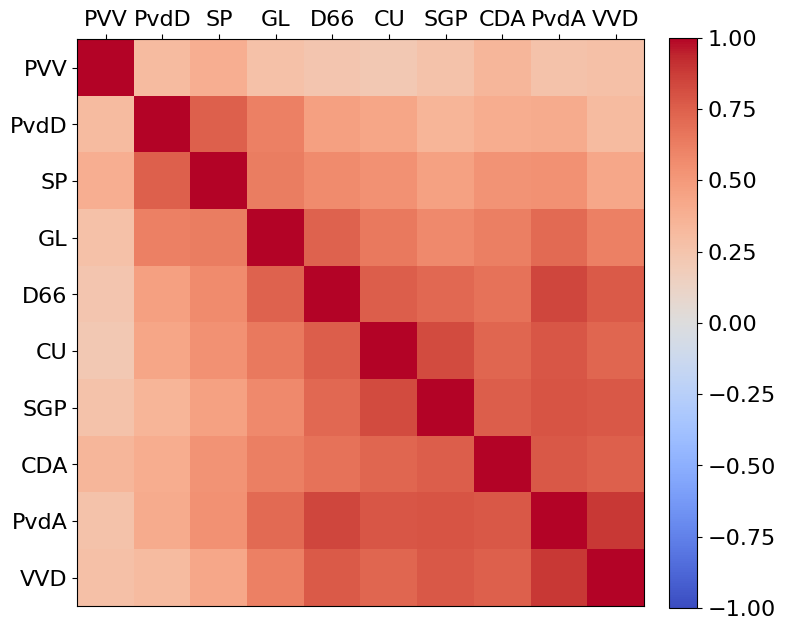

In [961]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(sym_correlation_matrix.to_numpy(), cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.xaxis.tick_top()

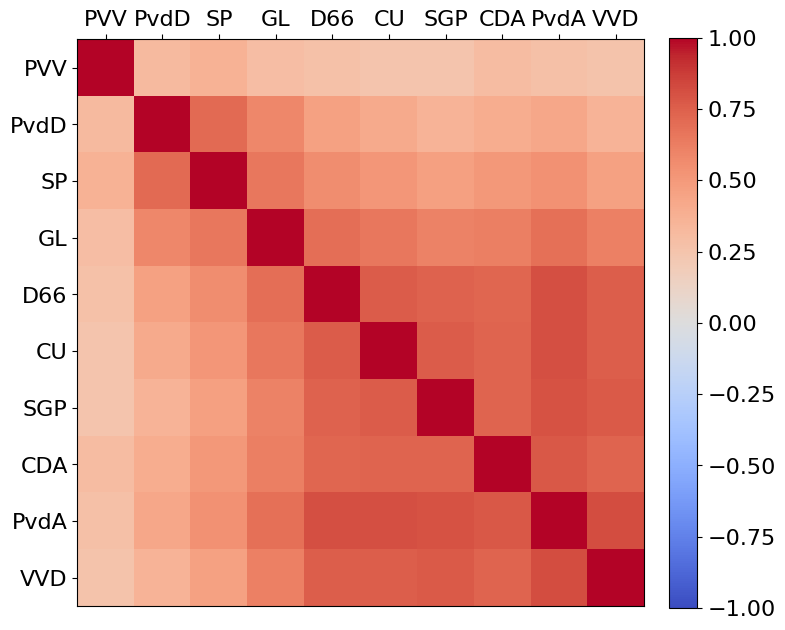

In [962]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(corr2(new_pvec), cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.xaxis.tick_top()

In [588]:
matrix = np.random.uniform(-1, 1, size=(10, 10))
symmetric_matrix = (matrix + matrix.T) / 2
np.fill_diagonal(symmetric_matrix, 0)

Z, pvec = pspins(symmetric_matrix)
Z, pvec

(np.float64(2825.5157527065376),
 array([1.72477396e-04, 2.96236801e-04, 5.48203176e-05, ...,
        5.48203176e-05, 2.96236801e-04, 1.72477396e-04]))

In [98]:
# four-point correlation between spins i, j, l, m
def corr4(pvec, i, j, l, m):
    corr = 0
    for k, sigma in enumerate(spins):
        corr += sigma[i]*sigma[j]*sigma[l]*sigma[m]*pvec[k]
    return corr

In [100]:
def eps_J(index):
    epsilon = 1e-5
    mat = np.zeros(45)
    mat[index] = epsilon
    return vec_to_J(mat)

In [101]:
corr2(pvec)

array([[ 1.        , -0.0702772 , -0.32789405, -0.01457245,  0.04551005,
         0.18893548,  0.13127069, -0.12531652,  0.22586104,  0.14593553],
       [-0.0702772 ,  1.        , -0.35259465,  0.22242763,  0.43065085,
         0.17842653,  0.33694024, -0.32734214,  0.39931519,  0.05974256],
       [-0.32789405, -0.35259465,  1.        , -0.18648515, -0.28934513,
        -0.39981602, -0.32362503,  0.49898063, -0.54316743, -0.10781264],
       [-0.01457245,  0.22242763, -0.18648515,  1.        ,  0.01437662,
        -0.16857603,  0.35071558, -0.03669189,  0.28022121,  0.35612628],
       [ 0.04551005,  0.43065085, -0.28934513,  0.01437662,  1.        ,
         0.22267109,  0.23240398, -0.43938382,  0.36658362, -0.20820662],
       [ 0.18893548,  0.17842653, -0.39981602, -0.16857603,  0.22267109,
         1.        ,  0.00821515, -0.38822319,  0.24880461, -0.2484228 ],
       [ 0.13127069,  0.33694024, -0.32362503,  0.35071558,  0.23240398,
         0.00821515,  1.        , -0.34522625

In [93]:
F2, Z2, pvec2 = pspins(symmetric_matrix + eps_J(1))

In [94]:
2*np.log(Z2/Z)/0.00001

np.float64(-0.03011641016834397)

In [50]:
vec = J_to_vec(symmetric_matrix)
vec_to_J(vec)

array([[ 0.        , -0.23678015,  0.00635228, -0.14731535, -0.63557275,
        -0.49622898,  0.4619109 , -0.18265392,  0.23639712, -0.21282886],
       [-0.23678015,  0.        , -0.60309593, -0.32184502, -0.24437516,
        -0.03077023, -0.26802609,  0.92153478, -0.42241473,  0.07736197],
       [ 0.00635228, -0.60309593,  0.        , -0.33268122, -0.28942689,
        -0.11995745, -0.96092815, -0.48139184,  0.15799909,  0.62999193],
       [-0.14731535, -0.32184502, -0.33268122,  0.        , -0.59830357,
         0.32123223,  0.10712056, -0.80401313, -0.04998617,  0.54208513],
       [-0.63557275, -0.24437516, -0.28942689, -0.59830357,  0.        ,
        -0.40812634, -0.29502874,  0.51626706,  0.25400566,  0.66221697],
       [-0.49622898, -0.03077023, -0.11995745,  0.32123223, -0.40812634,
         0.        ,  0.37844658,  0.28659147, -0.28262738,  0.2124518 ],
       [ 0.4619109 , -0.26802609, -0.96092815,  0.10712056, -0.29502874,
         0.37844658,  0.        ,  0.02886221

In [59]:
# four-point correlation between spins
def jacobian(pvec):
    corr = 0
    for k, sigma in enumerate(spins):
        corr += 0.5*np.outer(J_to_vec(np.outer(sigma,sigma)), J_to_vec(np.outer(sigma, sigma)))*pvec[k]
    
    corr -= 0.5*np.outer(J_to_vec(corr2(pvec)), J_to_vec(corr2(pvec)))

    return -2*corr

In [60]:
def Newton_J(J0):
    Z, pvec = pspins(J0)

    f0 = J_to_vec(sym_correlation_matrix.to_numpy() - corr2(pvec))
    J0_vec = J_to_vec(J0)

    jac = jacobian(pvec)

    Jnew_vec = J0_vec - np.dot(np.linalg.inv(jac), f0)
    Jnew = vec_to_J(Jnew_vec)

    Znew, pvecnew = pspins(Jnew)

    err = sym_correlation_matrix.to_numpy() - corr2(pvecnew)

    return Jnew, err

In [61]:
np.sum(sym_correlation_matrix.to_numpy() - corr2(pvec))

np.float64(53.56552330728728)

In [62]:
Jnew, err = Newton_J(symmetric_matrix)
np.sum(err)

np.float64(-37.10728891303161)

In [63]:
Znew, pvecnew = pspins(Jnew)

In [68]:
for i in np.arange(3):
    if i == 0:
        new_J, err = Newton_J(symmetric_matrix)
    print(np.sum(err))
    print(np.sum(new_J))
    new_J, err = Newton_J(new_J)
    
    

-37.10728891303161
121.78911146033268
nan
-2193514.5956979194
nan
nan


/var/folders/rf/01yzqyw96sn5k2_w7yg87fmd1r07vy/T/ipykernel_37484/3844087711.py:6: RuntimeWarning: overflow encountered in exp
  Z = np.sum(np.exp(pspins))
/var/folders/rf/01yzqyw96sn5k2_w7yg87fmd1r07vy/T/ipykernel_37484/3844087711.py:7: RuntimeWarning: overflow encountered in exp
  return Z, np.exp(pspins)/Z
/var/folders/rf/01yzqyw96sn5k2_w7yg87fmd1r07vy/T/ipykernel_37484/3844087711.py:7: RuntimeWarning: invalid value encountered in divide
  return Z, np.exp(pspins)/Z


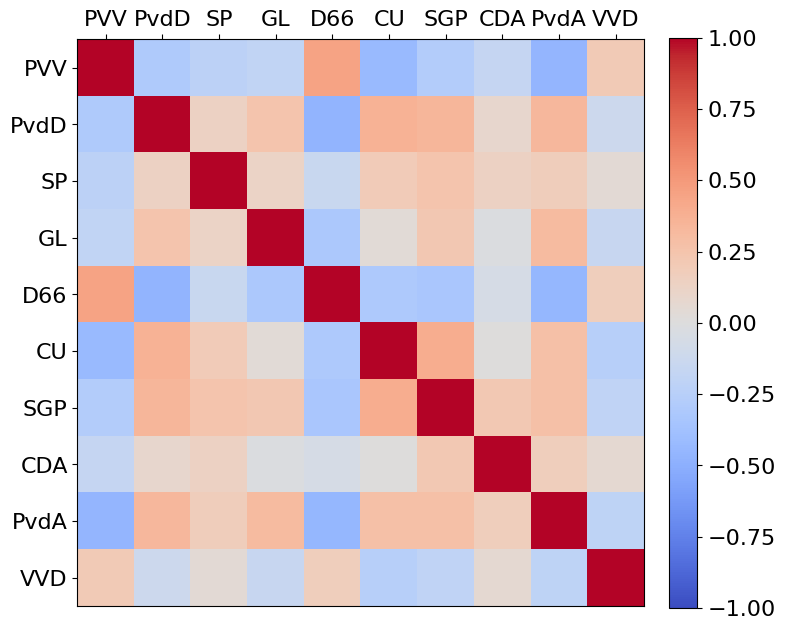

In [36]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(corr2(pvec), cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.xaxis.tick_top()

In [26]:
def optimize_J(sym_corr_matrix, initial_J, learning_rate=0.01, tolerance=1e-6, max_iterations=2):
    J = initial_J.copy()
    n = sym_corr_matrix.shape[0]
    
    for iteration in range(max_iterations):

        Z, pvec = pspins(J)

        error_matrix = np.zeros_like(sym_corr_matrix)
        jacobian_matrix = np.zeros_like(J)
        
        # Compute error matrix
        for i in range(n):
            for j in range(n):
                error_matrix[i, j] = sym_corr_matrix[i, j] - corr2(pvec, i, j)
        
        # Compute Jacobian matrix
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    for m in range(n):
                        jacobian_matrix[l, m] += 0.5 * (corr4(pvec, i, j, l, m) - corr2(pvec, i, j) * corr2(pvec, l, m))
        
        # Update J
        J -= learning_rate * jacobian_matrix * error_matrix
        
        print('one it done')

        # Check for convergence
        if np.linalg.norm(error_matrix) < tolerance:
            break
    
    return J

# Example usage
initial_J = symmetric_matrix
#sym_corr_matrix = np.random.rand(10, 10)  # Replace with actual sym_corr_matrix
optimized_J = optimize_J(sym_correlation_matrix.to_numpy(), initial_J)

one it done


KeyboardInterrupt: 

## Solving the inverse problem (symmetrised data)

Define the energy function and the Boltzmann distribution:

$$
\begin{split}
p(\{\sigma_i\}) &= \frac{1}{Z(J)} \exp\bigg(-\frac{1}{2} E(\{\sigma_i\}, J)\bigg) \\
E(\{\sigma_i\}, J) &= - \sum_{ij} J_{ij} \sigma_i \sigma_j \\
Z(J) &= \sum_{\{\sigma_i\}} \exp\bigg(-\frac{1}{2} E(\{\sigma_i\}, J)\bigg) 
\end{split}
$$

We would like to solve the 45 simultaneous equations for the elements of $J$:

$$
f_{ab}(J) = \langle \sigma_a \sigma_b \rangle_{\mathrm{exp}} - \sum_{\{\sigma_i\}} \sigma_a \sigma_b \, p(\{\sigma_i\}) = 0
$$

To help us numerically, we will need the Jacobian:

$$
\begin{split}
2\frac{\partial f_{ab} (J) }{\partial J_{ij}} &= - 2\sum_{\{\sigma_i\}} \sigma_a \sigma_b \, \frac{\partial p(\{\sigma_i\})}{\partial J_{ij}} 
%&= - \sum_{\{\sigma_i\}} \sigma_a \sigma_b \, (-\sigma_i \sigma_j + \langle \sigma_i \sigma_j \rangle ) \, p (\{ \sigma_i \}) \\
= \langle \sigma_a \sigma_b \sigma_i \sigma_j \rangle - \langle \sigma_a \sigma_b \rangle \langle \sigma_i \sigma_j \rangle
\end{split}
$$
The factor of 2 is to account for the symmetry $J_{ij} = J_{ji}$.

We have used the fact that:
$$
\langle \sigma_i \sigma_j \rangle = 2\frac{ \partial \log(Z(J))}{\partial J_{ij}}
$$

We can exploit the latter numerically to compute all the correlation functions: 
$$
\langle \sigma_i \sigma_j \rangle \approx \frac{2}{Z(J)} \frac{Z(J+\delta J_{ij}) - Z(J)}{\epsilon}
$$

Similarly:
$$
\langle \sigma_a \sigma_b \sigma_i \sigma_j \rangle = \frac{4}{Z(J)}\frac{ \partial^2 Z(J)}{\partial J_{ab} \, \partial J_{ij}}
$$
and hence:
$$
\langle \sigma_a \sigma_b \sigma_i \sigma_j \rangle \approx \frac{4}{Z(J)} \frac{Z(J+\delta J_{ij} + \delta J_{ab}) - Z(J+\delta J_{ij}) - Z(J+ \delta J_{ab}) + Z(J)}{\epsilon^2}
$$

